In [20]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Phân tích quan hệ giữa chỉ số AQI và các yếu tố môi trường
---

Bản phân tích nhanh dưới đây được thực hiện dựa trên dữ liệu thu tại điểm quan trắc Trường đại học Phú Xuân (Huế) được cung cấp bởi anh Đàm Quang Minh.

Người thực hiện: Đinh Nho Hùng.

# _Phần 1 (thực hiện ngày 6/5/2020)_

## 1. Mô tả data

- Data gồm 8 chỉ số và hàm lượng sau: AQI US, AQI CN, PM2.5, PM10, CO2, Nhiệt độ (C), Nhiệt độ (F), Độ ẩm.

- Data được thu thập theo giờ từ ngày 2/1/2019 đến ngày 6/5/2020.

Một phần nhỏ của data được trình bày trong bảng sau:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import numpy as np
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
from sklearn import linear_model
from sklearn import preprocessing
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/nhohung/datasciencecoursera/master/historical_hourly_data_GLRT9TR.csv', parse_dates=True)
# df = pd.read_csv('historical_hourly_data_GLRT9TR.csv', parse_dates=True)

In [4]:
df = df.iloc[:,1:10]
df.Datetime = pd.to_datetime(df.Datetime)
df.set_index('Datetime', inplace = True)

In [5]:
df.head()

,AQI US,AQI CN,PM2.5 (ug/m3),PM10 (ug/m3),CO2 (ppm),Temperature (Celsius),Temperature (Fahrenheit),Humidity (%)
Datetime,,,,,,,,
2020-05-06 09:00:00,152,79,58,88,437.3,31.8,89.3,74.0
2020-05-06 08:00:00,153,80,59,87,445.8,30.4,86.7,78.8
2020-05-06 07:00:00,153,80,59,84,467.2,28.4,83.1,84.4
2020-05-06 06:00:00,152,77,57,73,492.0,26.9,80.4,88.3
2020-05-06 05:00:00,157,90,67,86,492.6,27.2,80.9,87.0


## 2. Phân tích trực quan sơ bộ

Trước tiên chúng ta quan sát phân bố tương quan giữa các cặp thông số:

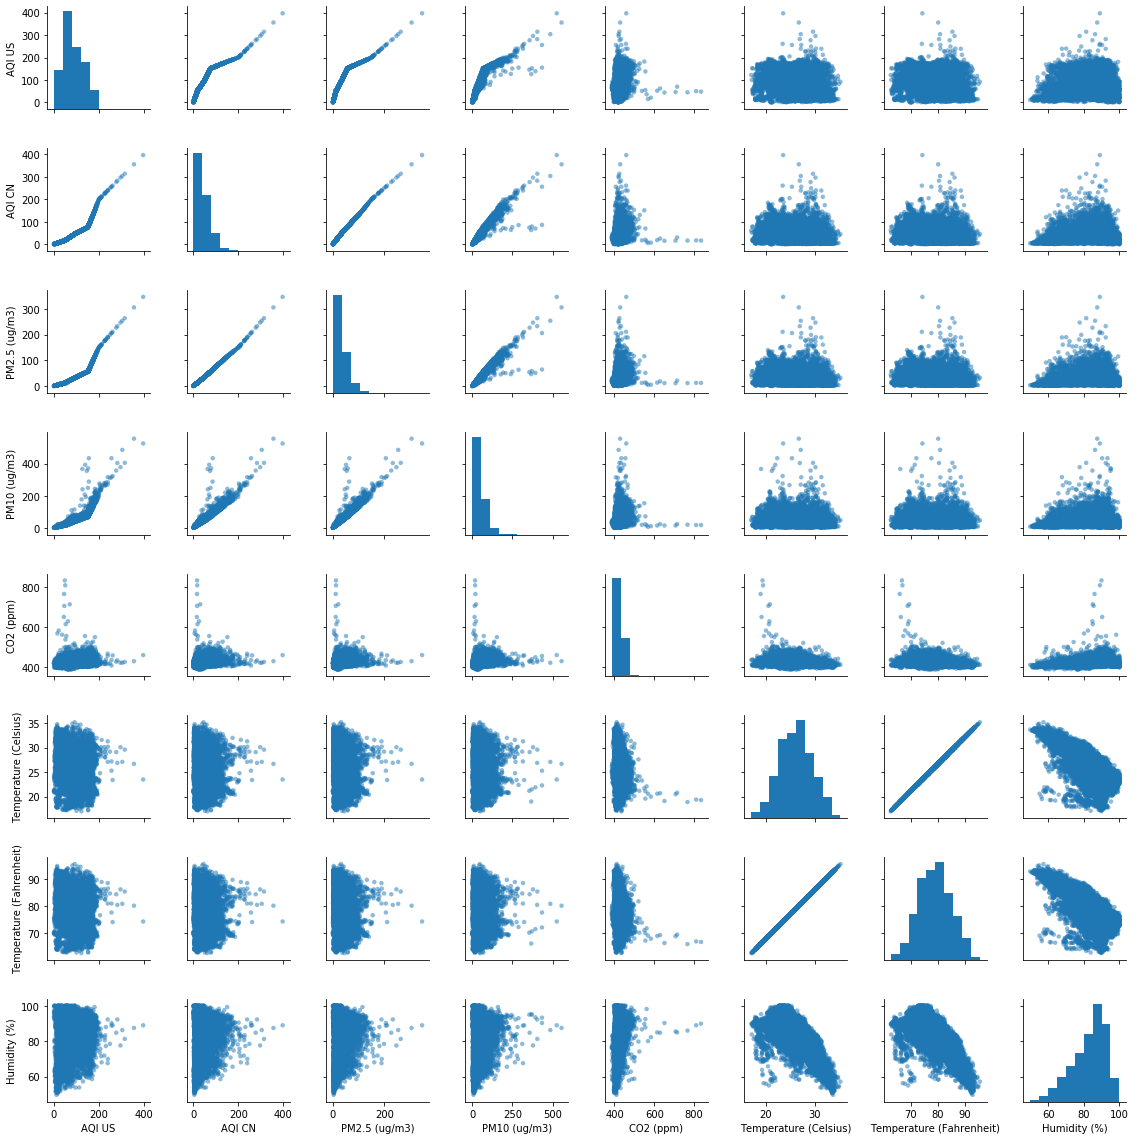

In [5]:
sns.pairplot(df, height=2, markers=".",
            plot_kws={'s':80, 'edgecolor':'none', 'alpha':0.5})

#### Nhận xét:

- Hai chỉ số AQI CN và AQI US có tương quan tuyến tính theo từng khoảng, và hoàn toàn bằng nhau với giá trị trên 200. Để xem giải thích chi tiết, xin mời vào địa chỉ [này](https://support.airvisual.com/en/articles/3029421-what-is-the-difference-between-china-us-aqi-%E7%BE%8E%E5%9B%BD%E7%A9%BA%E6%B0%94%E8%B4%A8%E9%87%8F%E6%8C%87%E6%95%B0%E5%92%8C%E4%B8%AD%E5%9B%BD%E7%A9%BA%E6%B0%94%E8%B4%A8%E9%87%8F%E6%8C%87%E6%95%B0%E6%9C%89%E4%BB%80%E4%B9%88%E5%8C%BA%E5%88%AB)


- Chỉ số nhiệt độ theo độ C và độ F hoàn toàn tương quan. Thông số độ F sẽ được bỏ đi cho các phân tích ở dưới.


- Hàm lượng PM 2.5 và PM10 có tương quan cao với cả 2 chỉ số AQI. PM 2.5 đặc biệt tuyến tính với AQI CN. PM10 có vài điểm ngoài khoảng thông dụng (outliers).


- Có biểu hiện tuyến tính yếu giữa nhiệt độ và độ ẩm


- Hàm lượng CO2, nhiệt độ và độ ẩm không quan sát thấy tương quan với các chỉ số AQI.

## 3. Phân tích tương quan AQI theo thời gian

### 3.1. Ngày trong tuần

Có nhiều ý kiến cho rằng mức độ ô nhiễm bụi mịn và AQI sẽ cao hơn vào các ngày trong tuần khi người dân sử dụng phương tiện giao thông nhiều hơn cuối tuần. Tuy nhiên, biểu diễn thống kê cho thấy không có sự khác biệt đó:

In [6]:
df['Weekday'] = df.index.weekday_name

In [22]:
t = df[['AQI CN', 'PM10 (ug/m3)', 'CO2 (ppm)', 'Weekday']]
t.loc[(t['Weekday'] == 'Saturday')|(t['Weekday'] == 'Sunday'), 'isweekend'] = 'Trong tuần' 
t.loc[~((t['Weekday'] == 'Saturday')|(t['Weekday'] == 'Sunday')), 'isweekend'] = 'Cuối tuần' 

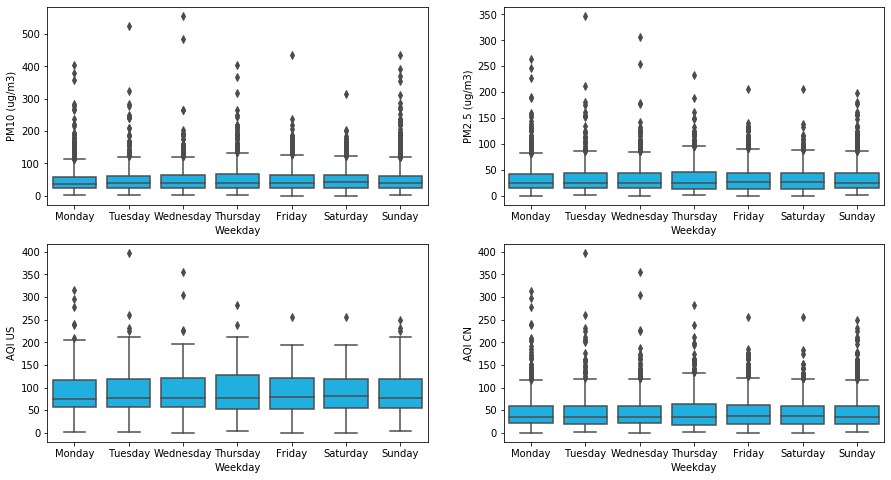

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
sns.boxplot(x="Weekday", y="PM10 (ug/m3)", data=df, color = 'deepskyblue',
            order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
            ax=axs[0,0])
sns.boxplot(x="Weekday", y="PM2.5 (ug/m3)", data=df, color = 'deepskyblue',
            order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
            ax=axs[0,1])
sns.boxplot(x="Weekday", y="AQI US", data=df, color = 'deepskyblue',
            order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
            ax=axs[1,0])
sns.boxplot(x="Weekday", y="AQI CN", data=df, color = 'deepskyblue',
            order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
            ax=axs[1,1])

### 3.2. Giờ trong ngày

Ý kiến về ô nhiễm không khí do giao thông của người dân có thể được kiểm chứng khi biểu diễn dữ liệu theo khung giờ. Ví dụ dưới đây thể hiện diễn biến AQI và bụi mịn trung bình (biểu đồ tập trung quanh giá trị trung bình).

In [7]:
df['Hour'] = df.index.hour

In [23]:
t = df[['AQI CN', 'PM10 (ug/m3)', 'PM2.5 (ug/m3)', 'CO2 (ppm)', 'Weekday', 'Hour', 'Temperature (Celsius)']]
t.loc[(t['Weekday'] == 'Saturday')|(t['Weekday'] == 'Sunday'), 'isweekend'] = 'Cuối tuần' 
t.loc[~((t['Weekday'] == 'Saturday')|(t['Weekday'] == 'Sunday')), 'isweekend'] = 'Trong tuần' 

In [26]:
df_wd = t[t.isweekend=='Trong tuần']
df_wk = t[t.isweekend=='Cuối tuần']

[(0, 60)]

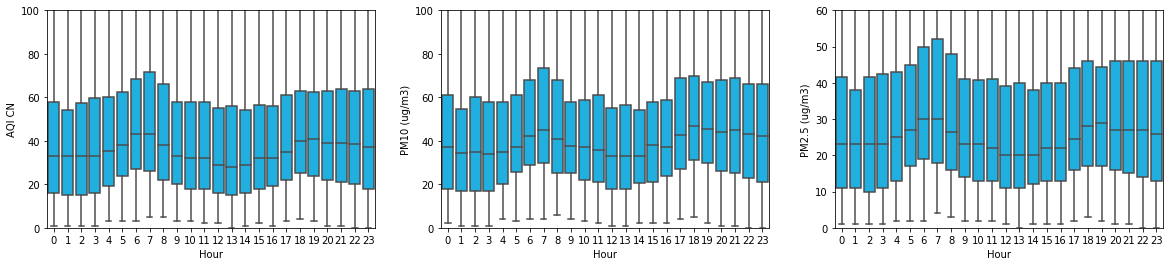

In [23]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 4))
sns.boxplot(x="Hour", y="AQI CN", data=df_wk, color = 'deepskyblue',
           ax=axs[0])
sns.boxplot(x="Hour", y="PM10 (ug/m3)", data=df_wk, color = 'deepskyblue',
           ax=axs[1])
sns.boxplot(x="Hour", y="PM2.5 (ug/m3)", data=df_wk, color = 'deepskyblue',
           ax=axs[2])
axs[0].set(ylim = (0,100))
axs[1].set(ylim = (0,100))
axs[2].set(ylim = (0,60))

- Có thể thấy rất rõ các chỉ số bụi mịn và chất lượng không khí tăng cao vào giờ cao điểm đi làm (7h sáng) và giờ người dân tham gia các hoạt động ngoài trời cuối ngày (sau 6h tối).


- Một lần nữa, khi quan sát dữ liệu theo giờ, kết quả vẫn không cho thấy sự khác biệt giữa ngày trong tuần và cuối tuần:

(350, 500)

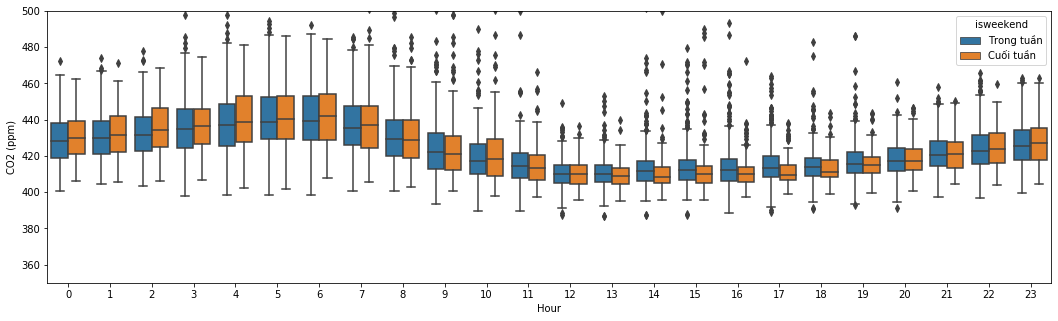

In [27]:
fig, ax = plt.subplots(figsize=(18,5))
ax = sns.boxplot(x="Hour", y="CO2 (ppm)", data=t, hue='isweekend')
plt.ylim([350,500])
# plt.ylim([0,100])

### 3.3. Phân tích tuyến tính

Ở phần này, chúng ta xây dựng nhanh một mô hình tương quan tuyến tính tiêu chuẩn (ordinary least squares regression) để tìm mối liên hệ định lượng giữa chỉ số AQI CN và các thông số môi trường khác. Các thông số môi trường này được chuẩn hoá về giá trị [0-1] trước khi đưa vào mô hình.

In [28]:
X = df[['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'CO2 (ppm)', 'Temperature (Celsius)', 'Humidity (%)']]
Y1 = df['AQI US']
Y2 = df['AQI CN']

In [30]:
x = X.values
# normalized_x = preprocessing.normalize(x)
normalized_x = preprocessing.MinMaxScaler().fit_transform(x)
normalized_X = pd.DataFrame(normalized_x)
normalized_X.columns = X.columns
normalized_X.set_index(X.index, inplace = True)

In [31]:
X1 = sm.add_constant(normalized_X) # adding a constant
 
model = sm.OLS(Y2, X1).fit()
predictions = model.predict(X1) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                 AQI CN   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 9.596e+05
Date:                Thu, 07 May 2020   Prob (F-statistic):               0.00
Time:                        08:29:38   Log-Likelihood:                -20466.
No. Observations:               11012   AIC:                         4.094e+04
Df Residuals:                   11006   BIC:                         4.099e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.66

/programming/si_python/gpython_crw01/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Kết quả thống kê này phù hợp với kết quả phân tích định tính từ biểu đồ đã trình bày ở 2 phần trên. Sau đây là một số điểm kết luận chính:

- Mô hình tuyến tính xấp xỉ rất tốt chỉ số AQI CN với giá trị R2 cao.


- Sau khi chuẩn hoá giá trị các biến, bảng hệ số cho thấy PM2.5 có tương quan cao nhất với AQI. Các chỉ số PM10, Nhiệt độ và Độ ẩm tuy có  nghĩa thống kê nhưng độ ảnh hưởng thấp hơn nhiều so với PM 2.5.


- Hàm lượng CO2 có ảnh hưởng thấp nhất với P-value lớn hơn độ tin cậy 0.05. Về mặt ý nghĩa thống kê, CO2 không có tương quan với AQI.

## 4. Kết luận phân tích nhanh

- Kết quả phân tích trực quan cho thấy các chỉ số không khí (AQI) và môi trường (PM) thay đổi có trật tự theo thời gian trong ngày. Một lý do giải thích cho hiện tượng này là hoạt động của con người.


- Kết quả phân tích trực quan định tính và xây dựng mô hình tuyến tính định lượng cho thấy hàm lượng bụi mịn PM 2.5 và PM 10 có tương quan cao nhất với chỉ số chất lượng không khí AQI CN. Ngược lại, hàm lượng CO2 không có ý nghĩa thống kê trong tương quan với AQI.


- Xin lưu ý, về mặt thống kê, chúng ta chỉ có thể kết luận AQI và PM 2.5 có tương quan cao. Tuy nhiên, dựa trên nguyên tắc tính AQI (link tham khảo ở mục 2 bên trên), chỉ số này có liên quan trực tiếp đến PM 2.5. Vì vậy, về bản chất, 2 đại lượng này phụ thuộc tuyến tính với nhau.

---

# _Phần 2 (thực hiện ngày 7/5/2020)_

Trong phần này, chúng ta nhìn chi tiết hơn về biến động của chỉ số không khí vào các dịp lễ tháng, dịp Tết âm lịch 2020 (Canh Tý) và phân tích kỹ hơn mối liên hệ giữa AQI và độ ẩm.

## 5. Các ngày lễ tháng

Ngoài các ngày mùng một và ngày rằm, tác giả dữ liệu gợi ý thêm ngày 23/5 âm lịch (theo lịch sử vào năm Ất Dậu 1885, đây là ngày kinh thành Huế thất thủ), mục tiêu nghiên cứu ảnh hưởng của tục cúng đốt lên chất lượng không khí. Số liệu được lấy ra 2 ngày trước các ngày cần quan tâm.

So sánh thống kê chất lượng không khí theo thời gian trong ngày của các dịp trên như sau:

In [8]:
t=df
t['date'] = t.index.date
t['date'] = t['date'].astype(str)

In [ ]:
# t['cung2'] = t['date'].apply(lambda x: 'mung1' if x in ['2019-01-06',
#                                                        '2019-02-05',
#                                                        '2019-03-06',
#                                                        '2019-04-05',
#                                                        '2019-05-05',
#                                                        '2019-06-03',
#                                                        '2019-07-03',
#                                                        '2019-08-01',
#                                                        '2019-08-30',
#                                                        '2019-09-29',
#                                                        '2019-10-28',
#                                                        '2019-11-26',
#                                                        '2019-12-26',
#                                                        '2020-02-23',
#                                                        '2020-03-24',
#                                                        '2020-04-23',] else ('ram' if x in ['2019-01-20',
#                                                                                            '2019-02-19',
#                                                                                            '2019-03-20',
#                                                                                            '2019-04-19',
#                                                                                            '2019-05-19',
#                                                                                            '2019-06-17',
#                                                                                            '2019-07-17',
#                                                                                            '2019-08-15',
#                                                                                            '2019-09-13',
#                                                                                            '2019-10-13',
#                                                                                            '2019-11-11',
#                                                                                            '2019-12-10',
#                                                                                            '2020-01-09',
#                                                                                            '2020-02-08',
#                                                                                            '2020-03-08',
#                                                                                            '2020-04-07',
#                                                                                           ] else ('235' if x in ['2019-06-25'] else 'thuong')))

In [19]:
t['cung2'] = t['date'].apply(lambda x: 'mùng 1' if x in ['2019-01-05','2019-01-04',
                                                       '2019-02-04','2019-02-03',
                                                       '2019-03-05','2019-03-04',
                                                       '2019-04-04','2019-04-03',
                                                       '2019-05-04','2019-05-03',
                                                       '2019-06-02','2019-06-01',
                                                       '2019-07-02','2019-07-01',
                                                       '2019-07-31','2019-07-30',
                                                       '2019-08-29','2019-08-28',
                                                       '2019-09-28','2019-09-27',
                                                       '2019-10-27','2019-10-26',
                                                       '2019-11-25','2019-11-24',
                                                       '2019-12-25','2019-12-24',
                                                       '2020-02-22','2020-02-21',
                                                       '2020-03-23','2020-03-22',
                                                       '2020-04-22','2020-04-21',] else ('rằm' if x in ['2019-01-19','2019-01-18',
                                                                                                        '2019-02-18','2019-02-17',
                                                                                                        '2019-03-19','2019-03-18',
                                                                                                        '2019-04-18','2019-04-17',
                                                                                                        '2019-05-18','2019-05-17',
                                                                                                        '2019-06-16','2019-06-15',
                                                                                                        '2019-07-16','2019-07-15',
                                                                                                        '2019-08-14','2019-08-13',
                                                                                                        '2019-09-12','2019-09-11',
                                                                                                        '2019-10-12','2019-10-11',
                                                                                                        '2019-11-10','2019-11-09',
                                                                                                        '2019-12-09','2019-12-08',
                                                                                                        '2020-01-08','2020-01-07',
                                                                                                        '2020-02-07','2020-01-06',
                                                                                                        '2020-03-07','2020-01-06',
                                                                                                        '2020-04-06','2020-01-05',
                                                                                                       ] else ('23/5' if x in ['2019-06-24', '2019-06-23'] else 'thường')))

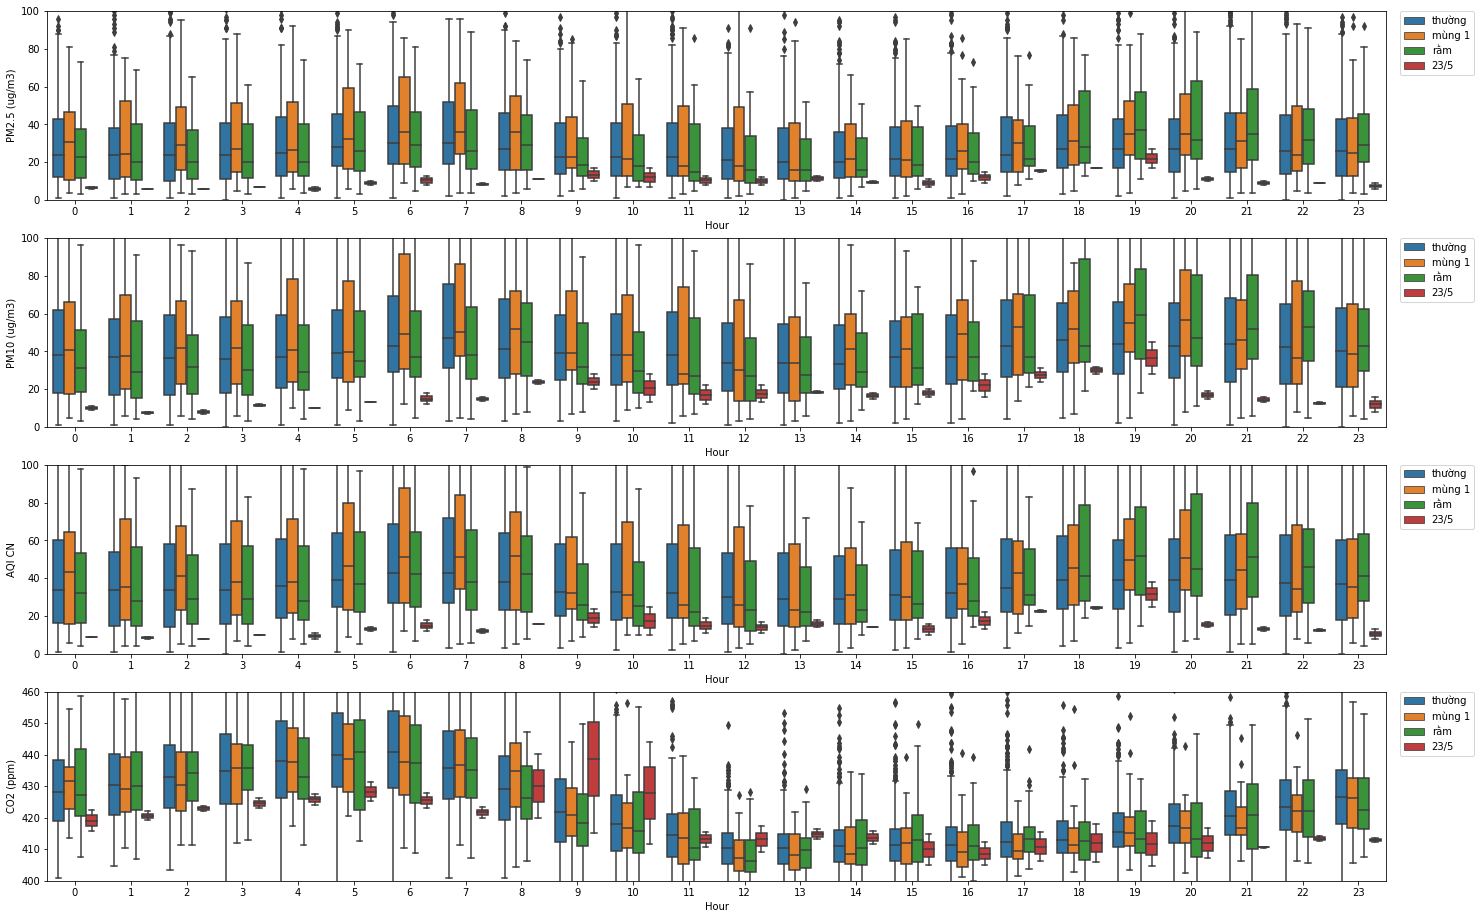

In [24]:
fig, axs = plt.subplots(nrows = 4, figsize=(24,16))
sns.boxplot(x="Hour", y="PM2.5 (ug/m3)", data=t, hue='cung2', ax=axs[0])
sns.boxplot(x="Hour", y="PM10 (ug/m3)", data=t, hue='cung2', ax=axs[1])
sns.boxplot(x="Hour", y="CO2 (ppm)", data=t, hue='cung2', ax=axs[3])
sns.boxplot(x="Hour", y="AQI CN", data=t, hue='cung2', ax=axs[2])

axs[0].set_ylim(0,100)
axs[1].set_ylim(0,100)
axs[3].set_ylim(400,460)
axs[2].set_ylim(0,100)

axs[0].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
axs[1].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
axs[2].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
axs[3].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# plt.ylim([350,500])
plt.show()

**Đặc trưng ngày 23/5 âm lịch:**

- CO2 rất cao từ 9h-13h, sau đó duy trì trung bình đến 20h

- Còn lại, các chỉ số khác, các khung giờ khác đều thấp hơn bình thường.

**Đặc trưng ngày mùng một:**

- AQI và bụi mịn cao hơn ngày thường, đặc biệt vào buổi sáng và tối từ 19-22h. 

- CO2 bình thường không khác biệt.

**Đặc trưng ngày rằm:**

- AQI và bụi mịn cao hơn ngày thường trong khoảng 18-21h (cao hơn cả mùng một).

- CO2 bình thường không khác biệt.  

*Ghi chú:*
- *Trừ ngày 23/5 âm lịch, các nhận định bên trên cho ngày mùng một và rằm dựa trên miền giá trị và/hoặc giá trị trung bình.*

- *Trong bài này, chúng ta chưa kiểm tra định lượng nhưng kết quả biểu diễn trực quan cho thấy không có khác biệt về mặt ý nghĩa thống kê.*
        
- *Nếu các kiểm tra định lượng thống kê được thực hiện, hãy lưu ý số lượng mẫu của nhóm các ngày đặc biệt là nhỏ hơn rất nhiều so với ngày thường (trong trường hợp này, tỷ lệ mẫu khoảng 2:30).*

## 6. Ghi nhận vào Tết âm lịch 2020

Hãy cùng nhìn vào một vài chỉ số không khí trong khoảng 1.5 tháng trước và sau dịp Tết

In [7]:
df.drop('Temperature (Fahrenheit)', 1, inplace = True)

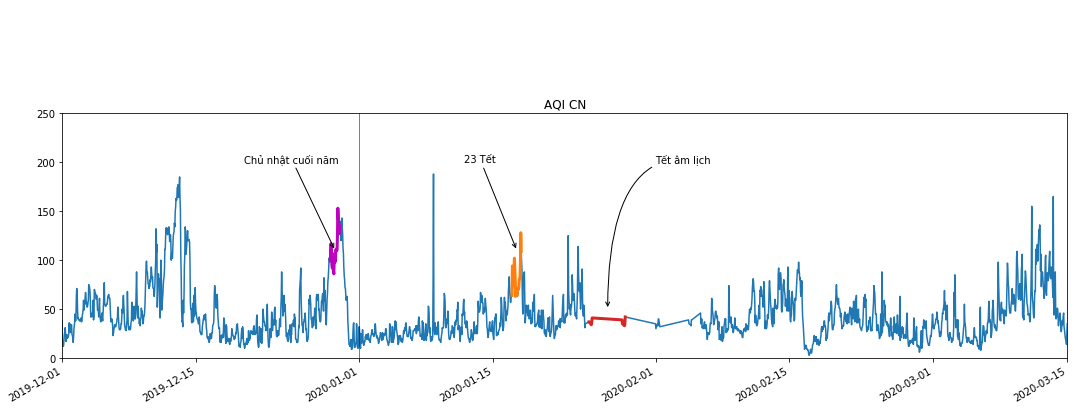

In [26]:
fig, ax = plt.subplots(figsize=(18,5))
ax = df['AQI CN'].plot()
ax = df.loc['2020-01-17','AQI CN'].plot(linewidth = 3)
ax = df.loc['2020-01-25':'2020-01-28','AQI CN'].plot(color = 'tab:red',linewidth = 3)

ax = df.loc['2019-12-29','AQI CN'].plot(linewidth = 3, color='m')

plt.axvline(x='2020-01-01', linewidth = 0.5, color = 'k')

plt.xlim('2019-12-01','2020-03-15')

plt.ylim(0,250)

ax.annotate('Tết âm lịch', xy = ('2020-01-27', 50) , xycoords = 'data',
           xytext=('2020-02-01', 200), textcoords = 'data',
           arrowprops=dict(arrowstyle='->', connectionstyle = 'angle3, angleA=0,angleB=90'))
ax.annotate('23 Tết', xy = ('2020-01-17 12:00:00', 110) , xycoords = 'data',
           xytext=('2020-01-12', 200), textcoords = 'data',
           arrowprops=dict(arrowstyle='->', connectionstyle = 'arc3, rad=0'))
ax.annotate('Chủ nhật cuối năm', xy = ('2019-12-29 12:00:00', 110) , xycoords = 'data',
           xytext=('2019-12-20', 200), textcoords = 'data',
           arrowprops=dict(arrowstyle='->', connectionstyle = 'arc3, rad=0'))
ax.annotate('Tết dương lịch', xy=('2020-01-01', 350), xycoords='data')
plt.title('AQI CN')
plt.xlabel('')
plt.show()

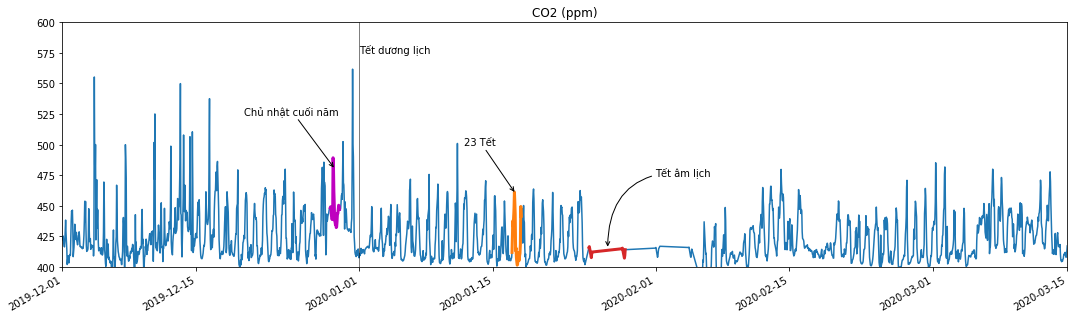

In [27]:
fig, ax = plt.subplots(figsize=(18,5))
ax = df['CO2 (ppm)'].plot()
ax = df.loc['2020-01-17','CO2 (ppm)'].plot(linewidth = 3)
ax = df.loc['2020-01-25':'2020-01-28','CO2 (ppm)'].plot(color = 'tab:red',linewidth = 3)

ax = df.loc['2019-12-29','CO2 (ppm)'].plot(linewidth = 3, color='m')

plt.axvline(x='2020-01-01', linewidth = 0.5, color = 'k')

plt.xlim('2019-12-01','2020-03-15')

plt.ylim(400,600)

ax.annotate('Tết âm lịch', xy = ('2020-01-27', 415) , xycoords = 'data',
           xytext=('2020-02-01', 475), textcoords = 'data',
           arrowprops=dict(arrowstyle='->', connectionstyle = 'angle3, angleA=0,angleB=90'))
ax.annotate('23 Tết', xy = ('2020-01-17 09:00:00', 460) , xycoords = 'data',
           xytext=('2020-01-12', 500), textcoords = 'data',
           arrowprops=dict(arrowstyle='->', connectionstyle = 'arc3, rad=0'))
ax.annotate('Chủ nhật cuối năm', xy = ('2019-12-29 12:00:00', 480) , xycoords = 'data',
           xytext=('2019-12-20', 525), textcoords = 'data',
           arrowprops=dict(arrowstyle='->', connectionstyle = 'arc3, rad=0'))
ax.annotate('Tết dương lịch', xy=('2020-01-01', 575), xycoords='data')
plt.title('CO2 (ppm)')
plt.xlabel('')
plt.show()

Một số quan sát có thể nhận thấy như sau:

- Vào ngày 23 Tết, chỉ số AQI cao hơn so với những ngày xung quanh, nhưng chưa phải cực điểm (ví dụ, so với tuần thứ hai của tháng 12/2019). Cũng trong ngày này, chỉ số CO2 dao động trong khoảng bình thường như quan sát ở những ngày khác.


- Số liệu AQI cho thấy mức độ xấu rất cao vào ngày chủ nhật cuối năm 2019 (ngày 29/12). Điều tương tự cũng quan sát được ở hàm lượng CO2 nhưng mức CO2 cao còn kéo dài đến hết ngày 31/12. Tuy nhiên mức CO2 thấp chỉ duy trì vào ngày đầu năm mới dương lịch, còn AQI duy trì được khoảng một tuần sau đó.


- Trong bốn ngày đầu năm Tết âm lịch, số liệu AQI và CO2 ghi nhận được rất thấp và ổn định. Tuy nhiên, rất đáng tiếc điều này không có ý nghĩa so sánh vì số liệu thu được vào những ngày này chỉ gồm 5 mẫu vào buổi sáng như biểu diễn trong biểu đồ dưới đây:

In [29]:
a = df
a['Date'] = a.index.date
b = pd.DataFrame(df.groupby('Date').count().iloc[:,0])
b.reset_index(inplace=True)
a['Date'] = a['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
b['Date'] = b['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
c = a.merge(b, left_on='Date', right_on='Date', how='inner')
c.set_index(a.index, inplace=True)

In [30]:
def plot_colourline(x,y,c):
    c = cm.rainbow((c-np.min(c))/(np.max(c)-np.min(c)))
    ax = plt.gca()
    for i in np.arange(len(x)-1):
        ax.plot([x[i],x[i+1]], [y[i],y[i+1]], c=c[i])
    return

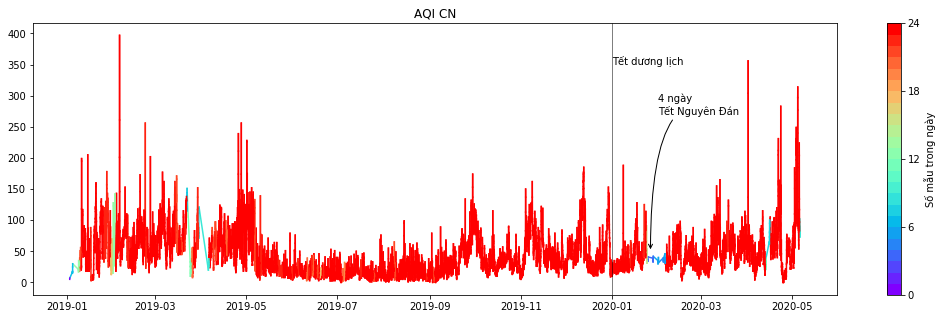

In [31]:
fig,ax = plt.subplots(figsize=(18,5))

x=c.index#[-700:]
y=c['AQI CN']#[-700:]
prop=c['AQI US_y']#[-700:]
ax = plot_colourline(x,y,prop)

plt.axvline(x='2020-01-01', linewidth = 0.5, color = 'k')
plt.annotate('Tết dương lịch', xy=('2020-01-01', 350), xycoords='data')
plt.annotate('4 ngày\nTết Nguyên Đán', xy = ('2020-01-27', 50) , xycoords = 'data',
             xytext=('2020-02-01', 270), textcoords = 'data',
             arrowprops=dict(arrowstyle='->', connectionstyle = 'angle3, angleA=0,angleB=90'))

sm1=ScalarMappable(cmap=cm.get_cmap('rainbow',24))
sm1.set_array([0,24])
cbar= plt.colorbar(sm1, ticks=[0, 6, 12, 18, 24])
cbar.set_label('Số mẫu trong ngày')

plt.title('AQI CN')
plt.xlabel('')

plt.show()

Thay đổi chất lượng không khí theo thời gian (mùa, tháng) có thể được phân tích bằng phương pháp tương tự nhằm giải thích bằng các hoạt động sinh hoạt địa phương hoặc các sự kiện môi trường, chính trị có liên quan. Dành cho những cá nhân muốn tìm hiểu sâu hơn, dưới đây là số liệu của 7 phép đo trong tập dữ liệu:

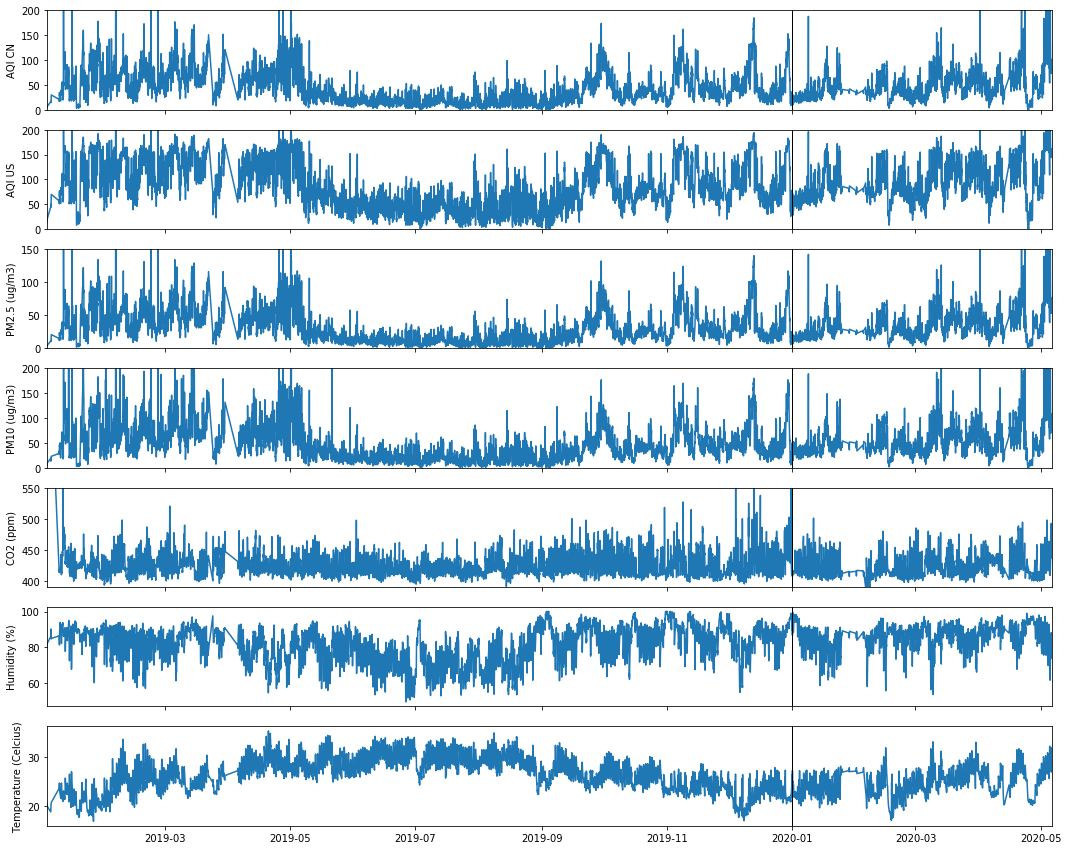

In [157]:
fig, ax = plt.subplots(nrows = 7, sharex=True, figsize=(18,15))

ax[0].plot(df['AQI CN'])
ax[0].set_ylabel('AQI CN')
ax[0].set_ylim(0,200)
ax[0].axvline(x='2020-01-01', linewidth = 1, color = 'k')
ax[1].plot(df['AQI US'])
ax[1].set_ylabel('AQI US')
ax[1].set_ylim(0,200)
ax[1].axvline(x='2020-01-01', linewidth = 1, color = 'k')

ax[2].plot(df['PM2.5 (ug/m3)'])
ax[2].set_ylabel('PM2.5 (ug/m3)')
ax[2].set_ylim(0,150)
ax[2].axvline(x='2020-01-01', linewidth = 1, color = 'k')
ax[3].plot(df['PM10 (ug/m3)'])
ax[3].set_ylabel('PM10 (ug/m3)')
ax[3].set_ylim(0,200)
ax[3].axvline(x='2020-01-01', linewidth = 1, color = 'k')

ax[4].plot(df['CO2 (ppm)'])
ax[4].set_ylabel('CO2 (ppm)')
ax[4].set_ylim(390,550)
ax[4].axvline(x='2020-01-01', linewidth = 1, color = 'k')
ax[5].plot(df['Humidity (%)'])
ax[5].set_ylabel('Humidity (%)')
ax[5].axvline(x='2020-01-01', linewidth = 1, color = 'k')
ax[6].plot(df['Temperature (Celsius)'])
ax[6].set_ylabel('Temperature (Celcius)')
ax[6].axvline(x='2020-01-01', linewidth = 1, color = 'k')

plt.xlim(np.min(df.index),np.max(df.index))
plt.show()

- Quan sát nhanh các biểu đồ ta có thể thấy chất lượng không khí và hàm lượng bụi mịn năm 2019 có những giai đoạn cao bất thường như vào tháng 5, 10-12 và cũng có những giai đoạn thấp bình ổn như từ tháng 6-9.

- Đặc biệt, những biến động tương tự cũng có mặt lặp lại trong nửa đầu năm 2020, gợi ý yếu tố mùa vụ. Các phân tích sâu hơn cần liên hệ với tập quán địa phương, và các sự kiện thường niên ở khu vực lấy mẫu.

## 7. Nghiên cứu mối liên hệ giữa AQI và Độ ẩm

### 7.1. Đặt vấn đề

Nội dung này được gợi ý bởi tác giả dữ liệu.

Trong công thức định nghĩa chỉ số AQI, không có yếu tố độ ẩm. Phân tích tuyến tính tiêu chuẩn bậc 1 ở mục 3.3 cũng đã chỉ ra độ ẩm không có liên hệ đáng kể về mặt thống kê với chỉ số AQI. Vì vậy ở phần này chúng ta sẽ dùng một số phương pháp nâng cao để tìm những tương quan phi tuyến (nếu có).

Đồng thời, để tìm được mối liên hệ mang tính khái quát hơn, một nhân tố thứ hai cũng sẽ được đưa vào mô hình. Dựa trên phân tích ở mục 3.3, CO2 bị loại vì không có ý nghĩa thống kê, hai chỉ số bụi mịn bị loại vì chúng có tương quan quá lớn và sẽ làm mờ nhân tố độ ẩm. Nhân tố nhiệt độ được chọn vì chênh lệch độ tương quan không quá cao, và trên thực tế, hai nhân tố này thường được coi là độc lập điển hình của thời tiết.

### 7.2. Phương pháp

Hai biến số (nhiệt độ và độ ẩm) được chuẩn hoá (min-max normalization) trước khi đưa vào mô hình dự đoán kết quả (AQI CN). Các phương pháp sử dụng để so sánh bao gồm:

- với biến số đầu vào: chuyển đổi đa thức (polynomial transformation) và chuyển đổi sang phân bố chuẩn (Gaussian và quantile distribution transformations)
- với kết quả dự đoán: chuyển đổi sang phân bố chuẩn (dùng lograrithm transform)

Ở đây, phép chuyển đổi sang phân bố chuẩn được sử dụng vì kết quả phân tích ở mục biểu đồ phân tích trực quan (mục 2) cho thấy AQI và độ ẩm có phân bố lệch (skewed). Đưa chúng về dạng phân bố chuẩn sẽ giúp ổn định hoá kết quả phân tích tuyến tính.

Với các phép chuyển đổi này, chúng ta không dùng phân tích tuyến tính tiêu chuẩn như mục 3.3 vì việc sử dụng hàm đa thức quá cao sẽ làm tăng nguy cơ "quá khớp" (over fitting). Để khắc phục điều này, phương pháp tuyến tính giới hạn trọng số (regularized linear regression) sẽ được sử dụng. Trong hai phương pháp tuyến tính giới hạn trọng số thông dụng là Ridge và Lasso, phương pháp Lasso sẽ được sử dụng trong bài này, vì tiêu chí giới hạn trọng số dựa trên sai số tuyệt đối (L1) - ổn định hơn với nhiễu (outlier) so với phương pháp Ridge dùng sai số bình phương (L2).

Trong bài này chúng ta dùng hàm đa thức bậc 7, phân tích Lasso với hệ số giới hạn trọng số (alpha) bằng 0.01. 

### 7.3. Kết quả

In [59]:
t = df[['AQI US', 'AQI CN', 'Humidity (%)', 'Temperature (Celsius)']]

In [60]:
X = t[['Humidity (%)', 'Temperature (Celsius)']]
Y2 = t['AQI CN']

In [61]:
x = X.values
normalized_x = preprocessing.MinMaxScaler().fit_transform(x)
normalized_X = pd.DataFrame(normalized_x)
normalized_X.columns = X.columns
normalized_X.set_index(X.index, inplace = True)

In [127]:
R2TransI = pd.DataFrame(columns=['LS','GL','QL'])

for i in range(1,8):
#     print(i)
    poly=PolynomialFeatures(i)
    poly_X = poly.fit_transform(normalized_X)
    
    # linear reg
    regr = linear_model.LinearRegression().fit(poly_X, Y2)
    ypredLR = regr.predict(poly_X)
#     print(r2_score(Y2, ypredLR))
    
    # Lasso linear reg
    linlasso = Lasso(alpha=0.01).fit(poly_X, Y2)
    ypredLS = linlasso.predict(poly_X)
#     print(r2_score(Y2, ypredLS))
    
    # Gaussian transform
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    Gauss_X = pt.fit_transform(poly_X)
    Glinlasso = Lasso(alpha=0.01).fit(Gauss_X, Y2)
    ypredGL = Glinlasso.predict(Gauss_X)
#     print(r2_score(Y2, ypredGL))
    
    # quantile transform
    qt = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
    quantile_X = qt.fit_transform(poly_X)
    
    Qlasso = Lasso(alpha=0.01).fit(quantile_X, Y2)
    ypredQL = Qlasso.predict(quantile_X)
#     print(r2_score(Y2, ypredQL))

    R2TransI = R2TransI.append({
                               'LS': r2_score(Y2, ypredLS),
                               'GL': r2_score(Y2, ypredGL),
                               'QL': r2_score(Y2, ypredQL),},
                              ignore_index=True)

In [125]:
Y2_trans = np.log1p(Y2)
R2TransO = pd.DataFrame(columns=['LS','GL','QL'])

for i in range(1,8):
#     print(i)
    poly=PolynomialFeatures(i)
    poly_X = poly.fit_transform(normalized_X)
    
    # linear reg
    regr = linear_model.LinearRegression().fit(poly_X, Y2_trans)
    ypredLR = regr.predict(poly_X)
#     print(r2_score(Y2_trans, ypredLR))
    
    # Lasso linear reg
    linlasso = Lasso(alpha=0.01).fit(poly_X, Y2_trans)
    ypredLS = linlasso.predict(poly_X)
#     print(r2_score(Y2_trans, ypredLS))
    
    # Gaussian transform
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    Gauss_X = pt.fit_transform(poly_X)
    Glinlasso = Lasso(alpha=0.01).fit(Gauss_X, Y2_trans)
    ypredGL = Glinlasso.predict(Gauss_X)
#     print(r2_score(Y2_trans, ypredGL))
    
    # quantile transform
    qt = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
    quantile_X = qt.fit_transform(poly_X)
    
    Qlasso = Lasso(alpha=0.01).fit(quantile_X, Y2_trans)
    ypredQL = Qlasso.predict(quantile_X)
#     print(r2_score(Y2_trans, ypredQL))
    
    R2TransO = R2TransO.append({
                               'LS': r2_score(np.log1p(Y2), ypredLS),
                               'GL': r2_score(np.log1p(Y2), ypredGL),
                               'QL': r2_score(np.log1p(Y2), ypredQL),},
                              ignore_index=True)

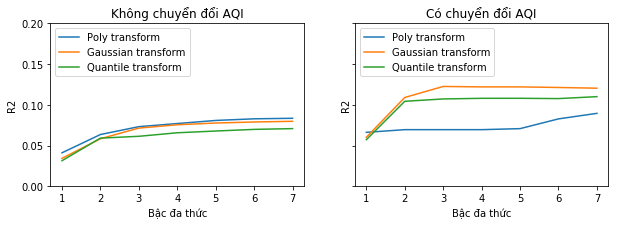

In [156]:
fig, ax = plt.subplots(ncols = 2, sharey=True, figsize=(10,3))

ax[0].plot(np.arange(1, 8), R2TransI)
ax[1].plot(np.arange(1, 8), R2TransO)

ax[0].set_xlabel('Bậc đa thức')
ax[1].set_xlabel('Bậc đa thức')
ax[0].set_ylabel('R2')
ax[1].set_ylabel('R2')

ax[0].set_yticks(np.arange(0, 0.25, step=0.05))
ax[1].set_yticks(np.arange(0, 0.25, step=0.05))
ax[0].legend(['Poly transform','Gaussian transform','Quantile transform'], loc=2)
ax[1].legend(['Poly transform','Gaussian transform','Quantile transform'], loc=2)

ax[0].title.set_text('Không chuyển đổi AQI')
ax[1].title.set_text('Có chuyển đổi AQI')

plt.show()

- Kết quả các phương pháp thử tuyến tính đa thức cho thấy độ tương quan khi thực hiện chuyển đổi miền phân bố đối với AQI nhìn chung cao hơn khi không có chuyển đổi. Hệ số tương quan cũng được cải thiện khi cả đầu vào (độ ẩm và nhiệt độ) cùng được chuyển sang phân phối chuẩn (Gaussian và Quantile). Điều này phù hợp với dự đoán vì bản chất các đối tượng có phân bố lệch (skewed).


- Kết quả còn cho thấy phân tích tương quan R2 đã dần bão hoà ở bậc 7. Sử dụng đa thức bậc cao hơn sẽ không cải thiện mô hình dự đoán.


- Hệ số R2 thấp (< 15%) kể cả khi đã dùng các phép chuyển đổi biến số và đối số cho thấy độ ẩm không có tương quan với chỉ số AQI.

## 8. Nhận định

- Phân tích các chỉ số trong những khoảng thời gian cụ thể sẽ gợi mở những biến đổi chi tiết của chất lượng không khí. Những biến đổi đặc trưng này cần được liên hệ với các hoạt động diễn ra tại thời điểm ấy. Các lý do ảnh hưởng chất lượng không khí có thể đến từ thiên nhiên (ví dụ: cháy rừng, núi lửa, bão cát) hoặc do con người (khai thác năng lượng, giao thông, sản xuất nông nghiệp).


- Quá trình phân tích các nguyên nhân trên cần kết hợp nhiều thông tin về tự nhiên, thực địa, hoạt động xã hội, văn hoá, chính trị... Khai thác tối ưu những nguồn thông tin này giúp chúng ta hiểu được vai trò của chúng tới chất lượng không khí, từ đó có thể đưa ra những biện pháp giảm thiểu ô nhiễm hoặc cải thiện không khí.


- Các phân tích định lượng được khuyến khích sử dụng để tìm mối tương quan giữa các yếu tố trong dữ liệu. Để có những phân tích có nghĩa, cần hiểu rõ bản chất của các đối tượng (ví dụ có một thành phần của AQI được tính từ nồng độ bụi mịn), nguồn dữ liệu (địa điểm quan trắc, chất lượng phép đo). Cần lưu ý, những quan sát và kết luận có giá trị tham khảo chỉ đúng với tập dữ liệu đang được phân tích, không có tính phổ quát để áp dụng cho địa phương khác.